In [1]:
# sentiment_pipeline_template.py

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm
from collections import Counter
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.utils import class_weight
from matplotlib import font_manager as fm
from konlpy.tag import Okt
import time
import itertools

okt = Okt()
font_path = "C:/Windows/Fonts/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False

# 전처리 함수

def preprocess_for_training(text, stopwords):
    text = str(text)
    tokens = okt.morphs(text)
    return [t for t in tokens if t not in stopwords]

# 예측 함수

def predict_sentiment(text, tokenizer, model, stopwords, max_len=70):
    filtered = preprocess_for_training(text, stopwords)
    sequence = tokenizer.texts_to_sequences([' '.join(filtered)])
    padded = pad_sequences(sequence, maxlen=max_len)
    prob = model.predict(padded)[0][0]
    label = '긍정' if prob > 0.5 else '부정'
    return label, prob

# 자동 하이퍼파라미터 튜닝 및 학습

def run_experiments(X_train_pad, y_train, X_texts, stopwords, tokenizer):
    embedding_dims = [32, 64]
    lstm_units_list = [32, 64]
    learning_rates = [1e-3, 1e-4]
    batch_sizes = [64, 128]
    max_len = 70

    all_combinations = list(itertools.product(embedding_dims, lstm_units_list, learning_rates, batch_sizes))

    for emb_dim, lstm_units, lr, batch_size in all_combinations:
        timestamp = time.strftime('%Y%m%d-%H%M%S')
        experiment_name = f"exp_{timestamp}_lr{lr}_bs{batch_size}_lstm{lstm_units}"
        log_dir = f"./logs/{experiment_name}"
        os.makedirs(log_dir, exist_ok=True)

        csv_logger = CSVLogger(os.path.join(log_dir, 'training_log.csv'))
        es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
        mc = ModelCheckpoint(os.path.join(log_dir, 'best_model.h5'),
                             monitor='val_accuracy', save_best_only=True, verbose=1)

        model = Sequential([
            Embedding(input_dim=10000, output_dim=emb_dim, input_length=max_len),
            LSTM(lstm_units),
            Dropout(0.5),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])

        model.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=lr),
                      metrics=['accuracy'])

        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weights = dict(enumerate(class_weights))

        history = model.fit(
            X_train_pad, y_train,
            epochs=10,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[es, mc, csv_logger],
            class_weight=class_weights,
            verbose=0
        )

        # 성능 저장
        final_log_path = os.path.join(log_dir, 'summary.csv')
        with open(final_log_path, 'w', newline='', encoding='utf-8') as f:
            import csv
            writer = csv.writer(f)
            writer.writerow(['param', 'value'])
            writer.writerow(['embedding_dim', emb_dim])
            writer.writerow(['lstm_units', lstm_units])
            writer.writerow(['learning_rate', lr])
            writer.writerow(['batch_size', batch_size])
            writer.writerow(['val_accuracy_last', history.history['val_accuracy'][-1]])

        # 모델 저장
        model.save(os.path.join(log_dir, 'final_model.keras'))

        # 학습 데이터 예측 저장
        predictions = []
        for text in tqdm(X_texts, desc=f"Predicting for {experiment_name}"):
            label, prob = predict_sentiment(text, tokenizer, model, stopwords, max_len=max_len)
            predictions.append({'text': text, 'label': label, 'prob': prob})
        pd.DataFrame(predictions).to_csv(os.path.join(log_dir, 'train_predictions.csv'), index=False, encoding='utf-8-sig')

print("전체 감성 분석 유틸리티 + 자동화 실험 템플릿 완료")


✅ 전체 감성 분석 유틸리티 + 자동화 실험 템플릿 완료


In [2]:
import os
import pandas as pd

def load_experiment_logs(logs_dir="./logs"):
    results = []
    for exp in os.listdir(logs_dir):
        log_path = os.path.join(logs_dir, exp, 'training_log.csv')
        if os.path.exists(log_path):
            df = pd.read_csv(log_path)
            best_val_acc = df['val_accuracy'].max()
            best_epoch = df['val_accuracy'].idxmax()
            results.append({
                'experiment': exp,
                'best_val_accuracy': best_val_acc,
                'best_epoch': best_epoch,
                'log_path': log_path
            })
    return pd.DataFrame(results).sort_values(by="best_val_accuracy", ascending=False)

def select_best_model(logs_df):
    return logs_df.iloc[0]  # val_accuracy 가장 높은 실험 선택

In [3]:
import os
import pandas as pd

def print_best_model_report(logs_df):
    best = logs_df.iloc[0]
    print("[Best Model Report]")
    print(f"실험명:         {best['experiment']}")
    print(f"최고 Val Acc:  {best['best_val_accuracy']:.4f}")
    print(f"최고 Epoch:     {best['best_epoch']}")
    print(f"Train Acc:      {best['train_accuracy']:.4f}")
    print(f"Val Loss:       {best['val_loss']:.4f}")
    print(f"Train Loss:     {best['train_loss']:.4f}")
    print(f"로그 경로:      {best['log_path']}")


In [4]:
import matplotlib.pyplot as plt


# 폰트 설정
font_path = "C:/Windows/Fonts/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False

def plot_val_accuracy(logs_df, top_n=5):
    plt.figure(figsize=(12, 6))
    
    for _, row in logs_df.head(top_n).iterrows():
        df = pd.read_csv(row['log_path'])
        plt.plot(df['val_accuracy'], label=row['experiment'])
    
    plt.title(f"Top {top_n} 실험의 validation accuracy 비교")
    plt.xlabel("Epoch")
    plt.ylabel("Val Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Best Experiment: exp_20250715-192729_lr0.0001_bs64_lstm64


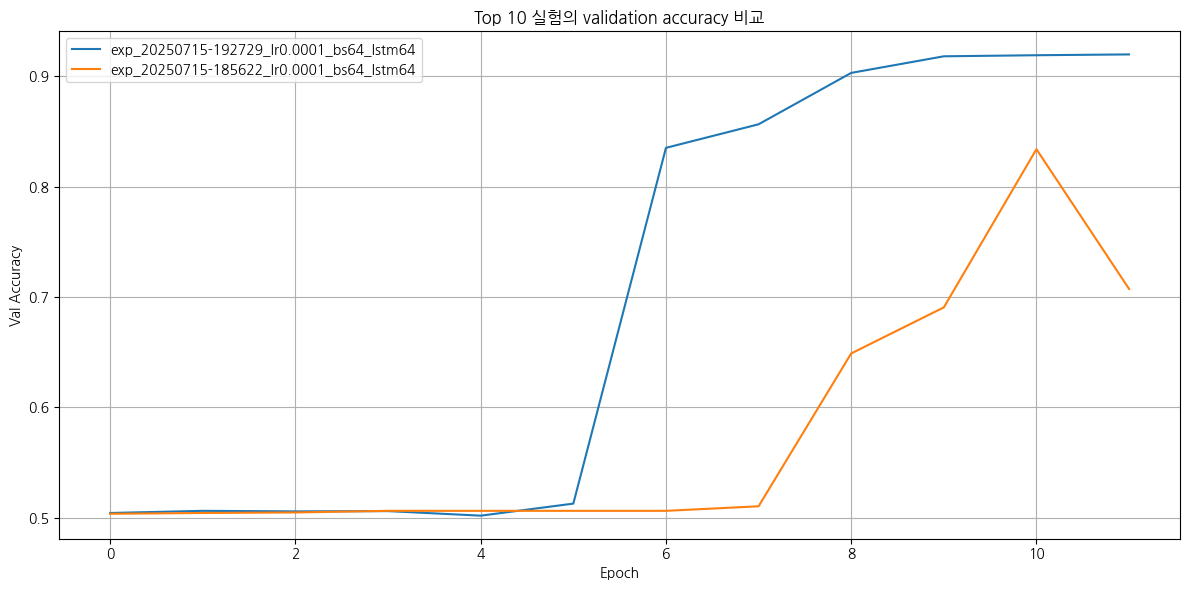

[Best Model Report]
실험명:         exp_20250715-192729_lr0.0001_bs64_lstm64
최고 Val Acc:  0.9197
최고 Epoch:     11


KeyError: 'train_accuracy'

In [7]:
logs_df = load_experiment_logs()
best_model_info = select_best_model(logs_df)
print("Best Experiment:", best_model_info['experiment'])
plot_val_accuracy(logs_df, top_n=10)
print_best_model_report(logs_df)